In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import cv2
import matplotlib.pylab as plt
import pandas as pd
%matplotlib inline

Mounted at /content/drive


## Libraries

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Load image's path and mask's path

In [3]:
import glob
images_path = glob.glob('/content/drive/MyDrive/AllMassFile/*.png')
mask_path = glob.glob('/content/drive/MyDrive/mask&images/*.png')

image_normal = glob.glob('/content/drive/MyDrive/in-breast/normal/*.png')
mask_normal = glob.glob('/content/drive/MyDrive/normalmask/*.png')

In [4]:
MASS_PATIENT_ID = ['53586896', '22580192', '22614236', '22580098', '24055445', '30011674', 
                   '20586934', '22670465', '24055502', '22670673', '20587612', '22614568', 
                   '20587902', '22614522', '50995789', '24055464', '20588216', '51049053', 
                   '53582656', '20588562', '27829188', '22614431', '22580341', '22613822', 
                   '24065584', '50997515', '51049107', '22580367', '22580244', '50996352', 
                   '22670147', '22580732', '50999008', '24065707', '22614127', '20588334', 
                   '20588536', '24065530', '22670324', '20586908', '30011507', '27829134', 
                   '53581406', '50998981', '20586986', '22678787', '50997461', '53580804', 
                   '22579730', '22670094', '53580858', '53586869', '50995762', '24065251', 
                   '20587810', '53581460', '22670855', '22580706', '30011553', '22670809', 
                   '22580419', '24055355', '53587014', '50994408', '22614379', '22670278', 
                   '24065289', '22614074', '24055274', '22670511', '50994354', '20587928', 
                   '22580393', '22580654', '20588046', '50994273', '20587758', '24065761', 
                   '22427751', '20587664', '50999432', '22580680', '22580038', '53587663', 
                   '20588308', '20588680', '30011727', '22678833', '22427705', '22614266', 
                   '22613650', '50999459', '24055483', '22678694', '20587994', '22678646', 
                   '53582683', '20586960', '51048765', '22670620', '22613770', '22427840', 
                   '20588190', '53586960', '50996406', '22613702', '51048738']

In [5]:
import os
file_names_mask =[]
for filename in os.listdir('/content/drive/MyDrive/mask&images'):
    if filename.endswith(".png"):
          if filename[:8] in MASS_PATIENT_ID:
              file_names_mask.append('/content/drive/MyDrive/mask&images/'+filename)

In [6]:
len(file_names_mask)

107

In [7]:
file_names_mask.sort()

In [8]:
file_names_mass =[]
for filename in os.listdir('/content/drive/MyDrive/AllMassFile'):
    if filename.endswith(".png"):
          if filename[:8] in MASS_PATIENT_ID:
              file_names_mass.append('/content/drive/MyDrive/AllMassFile/'+filename)

In [9]:
len(file_names_mass)

107

In [10]:
file_names_mass.sort()

In [11]:
len(image_normal),len(mask_normal)

(107, 107)

In [12]:
image_normal.sort(),mask_normal.sort()

(None, None)

## Data Visualization

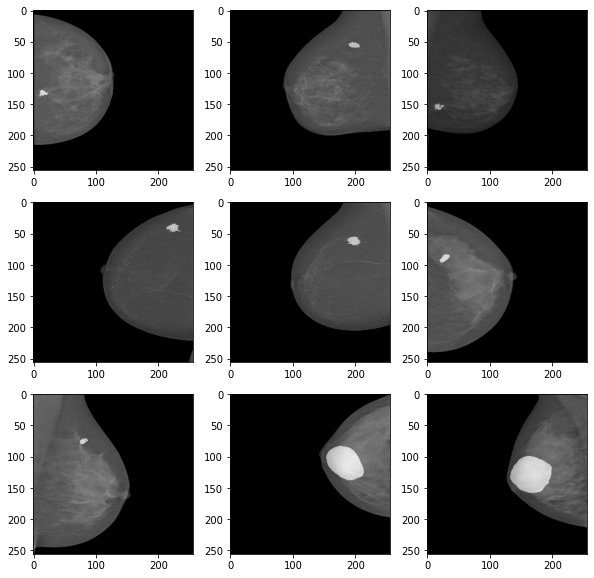

In [13]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=file_names_mass[i]
    msk_path=file_names_mask[i]
    img=cv2.imread(img_path)
    img=cv2.resize(img,(256,256))
    # img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    msk=cv2.resize(msk,(256,256))
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

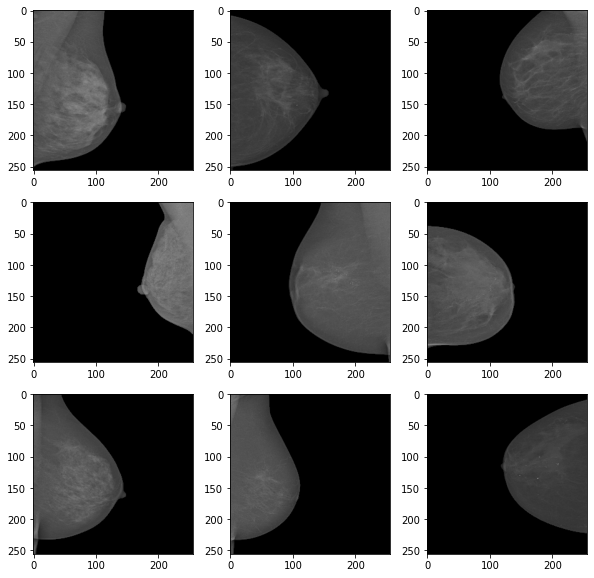

In [17]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=image_normal[i]
    msk_path=mask_normal[i]
    img=cv2.imread(img_path)
    img=cv2.resize(img,(256,256))
    # img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    msk=cv2.resize(msk,(256,256))
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

## Create data frame and split data on train set, validation set and test set

In [14]:
files = [*file_names_mass, *image_normal] 
mask = [*file_names_mask, *mask_normal] 

In [15]:
df = pd.DataFrame(data={"filename": files, 'mask' : mask})
shuffled = df.sample(frac=1)

df_train, df_test = train_test_split(shuffled,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(153, 2)
(39, 2)
(22, 2)


In [ ]:
shuffled

## Data genertator, data augmentation and adjust data

The steps_per_epoch parameter is key because an ImageDataGenerator can provide an infinite number of versions of each image. In this example, the batch_size parameter passed to flow tells the generator to create 10 images in each batch (each call to next). Dividing the number of images by the image batch size to calculate steps_per_epoch ensures that in each training epoch, the model is provided with one transformed version of each image in the dataset.

In [16]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(224,224),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

## Define loss function and metrics

In [22]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

## Training of Res-Unet without transfer learning

In [ ]:
# !pip3 install keras==2.3.1
!pip3 install -U segmentation-models

In [18]:
#Define the model
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [19]:
BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

In [20]:
EPOCHS = 150
BATCH_SIZE = 32
learning_rate = 1e-4

In [27]:
from segmentation_models import metrics
# define model
model_resnet = sm.Unet(BACKBONE)
# model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model_resnet.compile(optimizer=opt, loss=[sm.losses.bce_dice_loss, sm.losses.bce_jaccard_loss], 
                     metrics=[sm.metrics.precision, sm.metrics.recall, sm.metrics.f1_score, sm.metrics.iou_score])
print(model_resnet.summary())

85532672/85521592 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 stage1_unit3_relu1 (Activation  (None, None, None,   0          ['stage1_unit3_bn1[0][0]']       
 )                              64)                                                               
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, None, None,   0          ['stage1_unit3_relu1[0][0]']     
 D)                             64)                                                               
                                                                                                  
 stage1_unit3_conv1 (Conv2D)    (None, None, None,   36864       ['zero_padding2d_6[0][0]']       
                                64)                                                               
                                                                                                  
 stage1_unit3_bn2 (BatchNormali  (None, None, None,   256        ['stage1_unit3_conv1[0][0]']     
 zation)  

In [28]:
im_height = 224
im_width = 224

Found 153 validated image filenames.
Found 153 validated image filenames.
Epoch 1/150
10/10 [==============================] - ETA: 0s - loss: 1.5270 - precision: 0.0051 - recall: 0.4370 - f1-score: 0.0100 - iou_score: 0.0050Found 39 validated image filenames.
Found 39 validated image filenames.

Epoch 1: val_loss improved from inf to 2.02187, saving model to /content/drive/MyDrive/ModelCheckpoint/resenet_unet_segmentationusingNeewMetrics__.hdf5
10/10 [==============================] - 127s 12s/step - loss: 1.5270 - precision: 0.0051 - recall: 0.4370 - f1-score: 0.0100 - iou_score: 0.0050 - val_loss: 2.0219 - val_precision: 0.0074 - val_recall: 0.6784 - val_f1-score: 0.0147 - val_iou_score: 0.0074
Epoch 2/150
10/10 [==============================] - ETA: 0s - loss: 1.4389 - precision: 0.0054 - recall: 0.4197 - f1-score: 0.0106 - iou_score: 0.0053
Epoch 2: val_loss did not improve from 2.02187
10/10 [==============================] - 82s 9s/step - loss: 1.4389 - precision: 0.0054 - reca

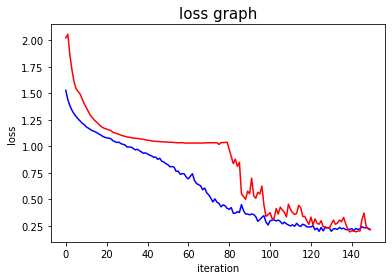

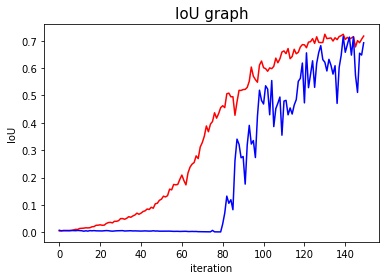

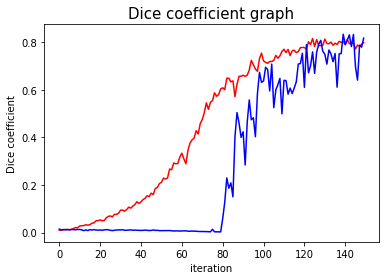

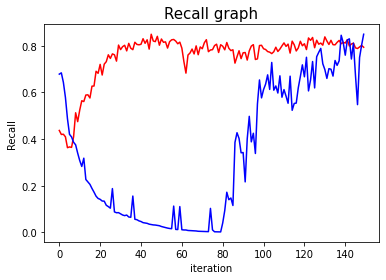

In [29]:
train_generator_args = dict(rotation_range=0.5,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.05,
                            zoom_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
callbacks = [ModelCheckpoint('/content/drive/MyDrive/ModelCheckpoint/resenet_unet_segmentationusingNeewMetrics__.hdf5', verbose=1, save_best_only=True)]

history = model_resnet.fit(train_gen,
                    steps_per_epoch=10, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=10)

## plotting curves

a = history.history

plt.figure(1)
plt.plot(a['loss'], 'b-')
plt.plot(a['val_loss'],'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)


plt.figure(2)
plt.plot(a['iou_score'], 'r-')
plt.plot(a['val_iou_score'], 'b-')
plt.xlabel('iteration')
plt.ylabel('IoU')
plt.title('IoU graph', fontsize = 15)


plt.figure(3)
plt.plot(a['f1-score'], 'r-')
plt.plot(a['val_f1-score'], 'b-')
plt.xlabel('iteration')
plt.ylabel('Dice coefficient')
plt.title('Dice coefficient graph', fontsize = 15)

plt.figure(4)
plt.plot(a['recall'], 'r-')
plt.plot(a['val_recall'], 'b-')
plt.xlabel('iteration')
plt.ylabel('Recall')
plt.title('Recall graph', fontsize = 15)

plt.show()

In [30]:
test_gen = train_generator(df_test, 22,
                                dict(),
                                target_size=(224, 224))
results = model_resnet.evaluate(test_gen, steps=10)

Found 22 validated image filenames.
Found 22 validated image filenames.
10/10 [==============================] - 29s 3s/step - loss: 0.2403 - precision: 0.9113 - recall: 0.6658 - f1-score: 0.7694 - iou_score: 0.6252


In [33]:
print("Test lost:   ",results[0])
print("precision:   ",results[1])
print("Recall   :   ",results[2])
print("f1-score :   ",results[3])
print("iou_score:   ",results[4])

Test lost:    0.24026177823543549
precision:    0.9113017320632935
Recall   :    0.6657506227493286
f1-score :    0.7694096565246582
iou_score:    0.6252363920211792


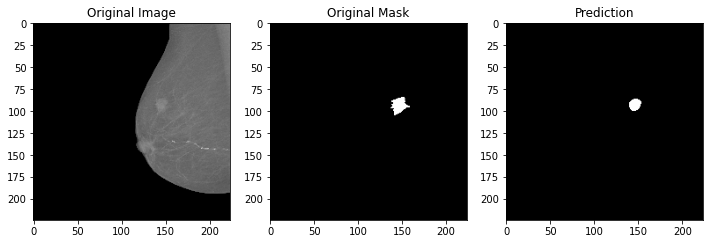

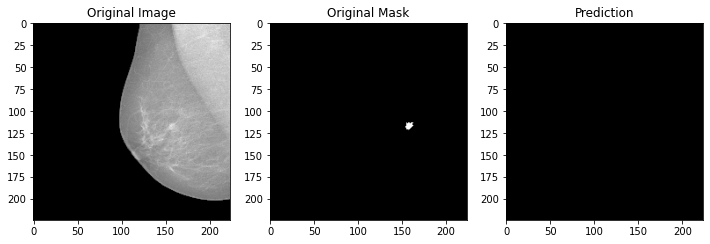

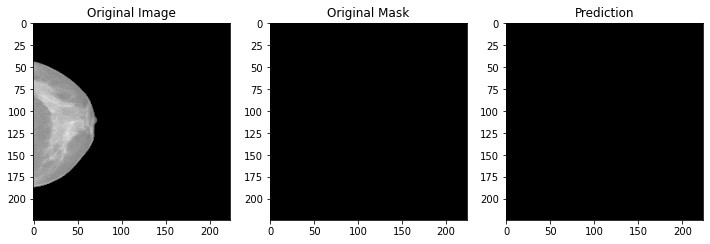

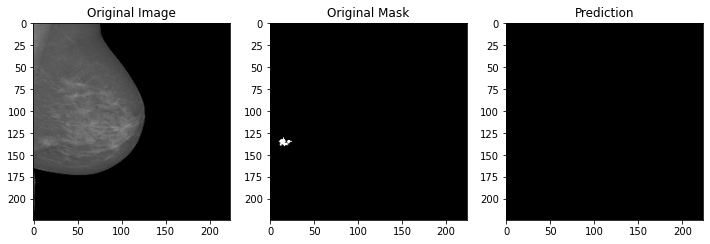

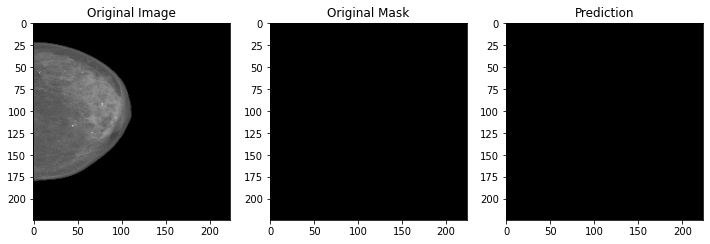

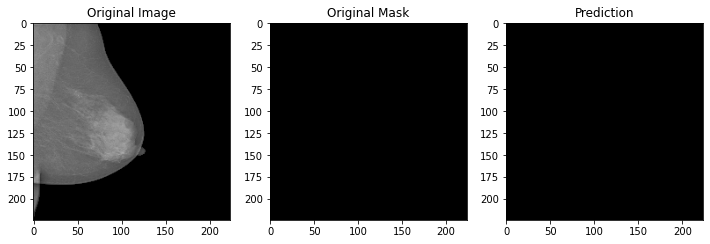

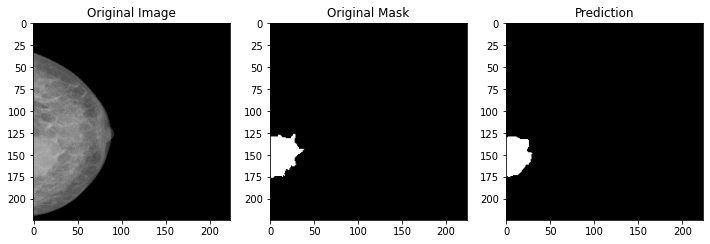

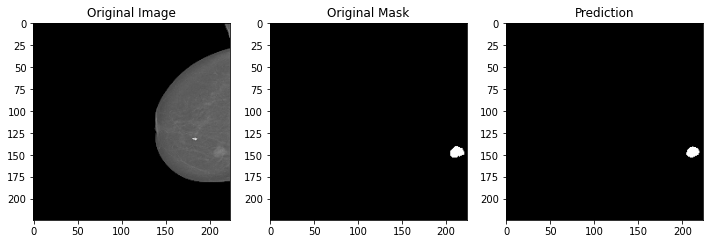

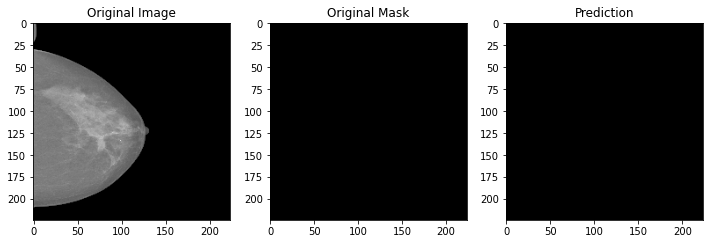

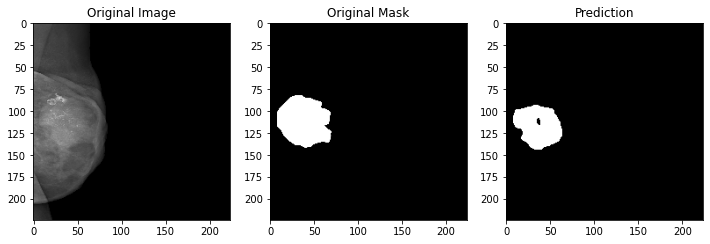

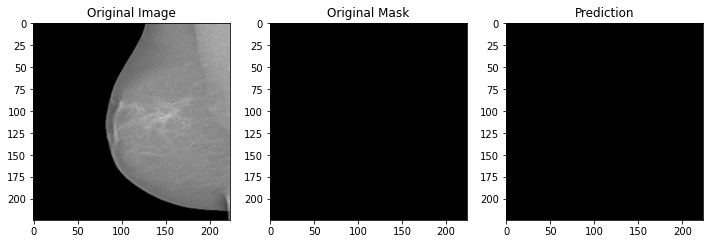

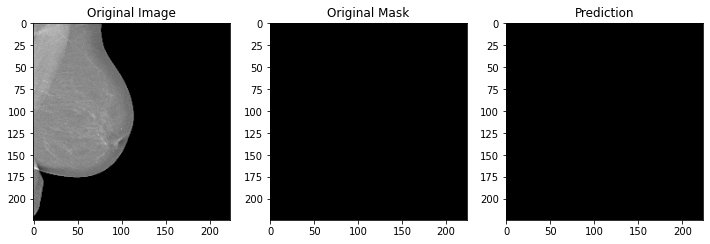

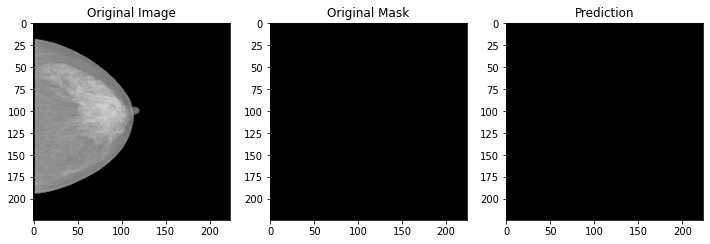

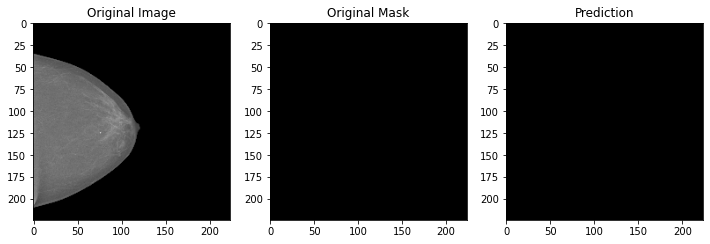

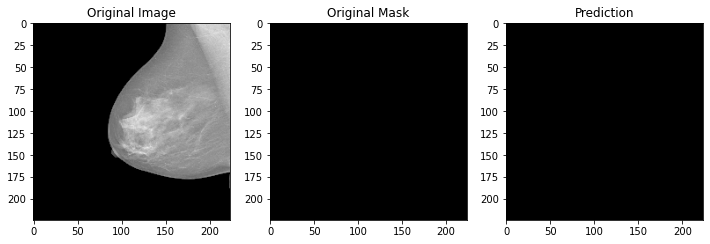

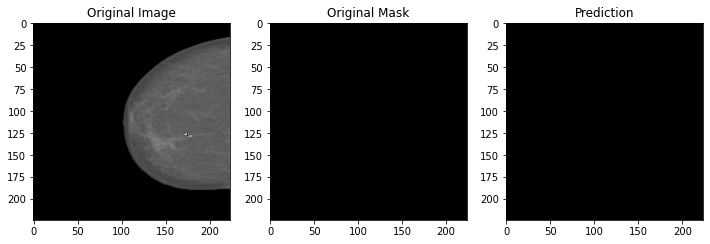

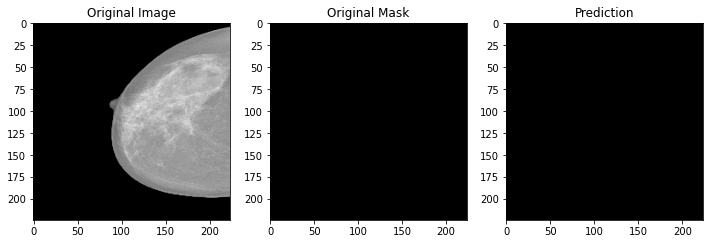

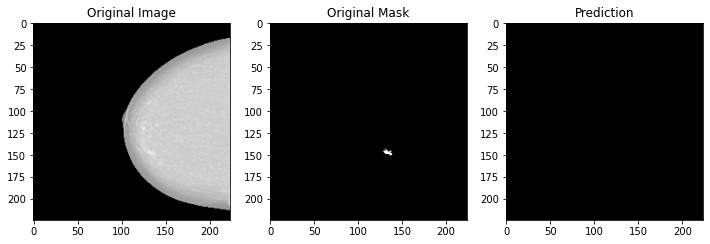

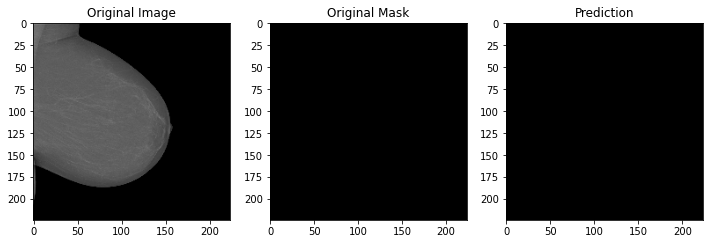

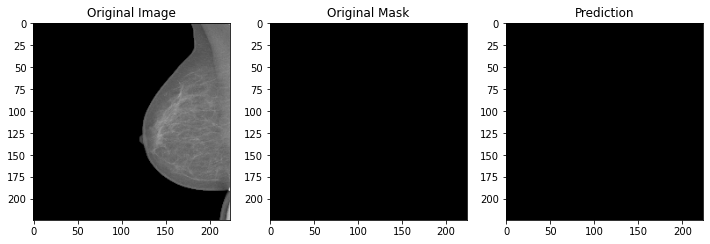

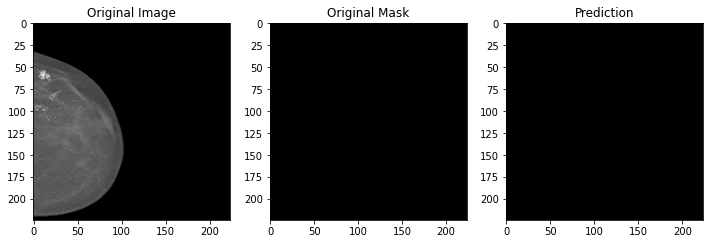

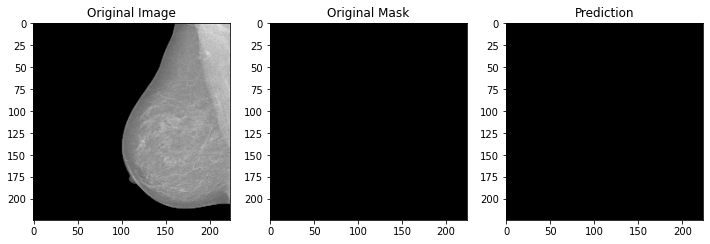

In [34]:
im_height, im_width = 224,224
for i in range(22):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[i])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model_resnet.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    mask = np.squeeze(cv2.imread(df_test['mask'].iloc[i]))
    mask = cv2.resize(mask ,(im_height, im_width))
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5,cmap='gray')
    plt.title('Prediction')
    plt.show()

## ResUnet Transfer learning without freezing the encoder

In [21]:
from segmentation_models import metrics
# define model
model_resnet2 = sm.Unet(BACKBONE,encoder_weights='imagenet',encoder_freeze=False)
# model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model_resnet2.compile(optimizer=opt, loss=[sm.losses.bce_dice_loss, sm.losses.bce_jaccard_loss], 
                     metrics=[sm.metrics.precision, sm.metrics.recall, sm.metrics.f1_score, sm.metrics.iou_score])
print(model_resnet2.summary())

85532672/85521592 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 stage2_unit1_conv2 (Conv2D)    (None, None, None,   147456      ['zero_padding2d_9[0][0]']       
                                128)                                                              
                                                                                                  
 stage2_unit1_sc (Conv2D)       (None, None, None,   8192        ['stage2_unit1_relu1[0][0]']     
                                128)                                                              
                                                                                                  
 add_3 (Add)                    (None, None, None,   0           ['stage2_unit1_conv2[0][0]',     
                                128)                              'stage2_unit1_sc[0][0]']        
                                                                                                  
 stage2_un

Found 153 validated image filenames.
Found 153 validated image filenames.
Epoch 1/150
10/10 [==============================] - ETA: 0s - loss: 1.3735 - precision: 0.0047 - recall: 0.3249 - f1-score: 0.0092 - iou_score: 0.0047Found 39 validated image filenames.
Found 39 validated image filenames.

Epoch 1: val_loss improved from inf to 1.60628, saving model to /content/drive/MyDrive/ModelCheckpoint/ResUnet Transfer learning without freezing the encoder.hdf5
10/10 [==============================] - 129s 12s/step - loss: 1.3735 - precision: 0.0047 - recall: 0.3249 - f1-score: 0.0092 - iou_score: 0.0047 - val_loss: 1.6063 - val_precision: 0.0069 - val_recall: 0.4574 - val_f1-score: 0.0135 - val_iou_score: 0.0068
Epoch 2/150
10/10 [==============================] - ETA: 0s - loss: 1.3147 - precision: 0.0053 - recall: 0.3376 - f1-score: 0.0105 - iou_score: 0.0053
Epoch 2: val_loss did not improve from 1.60628
10/10 [==============================] - 69s 8s/step - loss: 1.3147 - precision: 0.

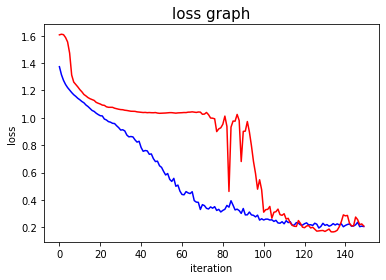

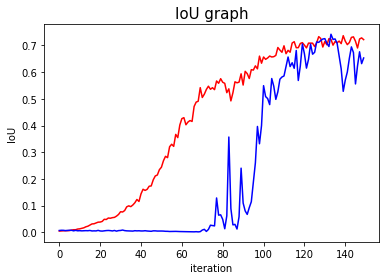

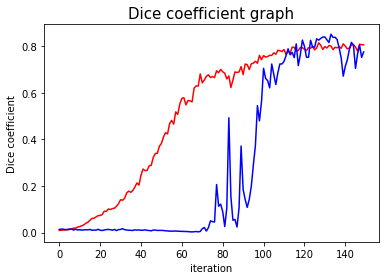

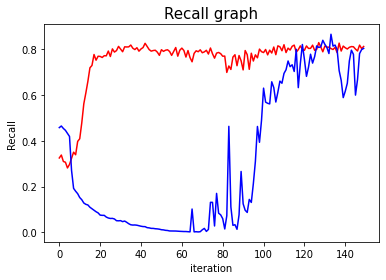

In [23]:
im_height, im_width = 224,224
train_generator_args = dict(rotation_range=0.5,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.05,
                            zoom_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
callbacks = [ModelCheckpoint('/content/drive/MyDrive/ModelCheckpoint/ResUnet Transfer learning without freezing the encoder.hdf5', verbose=1, save_best_only=True)]

history = model_resnet2.fit(train_gen,
                    steps_per_epoch=10, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=10)

## plotting curves

a = history.history

plt.figure(1)
plt.plot(a['loss'], 'b-')
plt.plot(a['val_loss'],'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)


plt.figure(2)
plt.plot(a['iou_score'], 'r-')
plt.plot(a['val_iou_score'], 'b-')
plt.xlabel('iteration')
plt.ylabel('IoU')
plt.title('IoU graph', fontsize = 15)


plt.figure(3)
plt.plot(a['f1-score'], 'r-')
plt.plot(a['val_f1-score'], 'b-')
plt.xlabel('iteration')
plt.ylabel('Dice coefficient')
plt.title('Dice coefficient graph', fontsize = 15)

plt.figure(4)
plt.plot(a['recall'], 'r-')
plt.plot(a['val_recall'], 'b-')
plt.xlabel('iteration')
plt.ylabel('Recall')
plt.title('Recall graph', fontsize = 15)

plt.show()

In [24]:
test_gen = train_generator(df_test, 22,
                                dict(),
                                target_size=(224, 224))
results = model_resnet2.evaluate(test_gen, steps=10)

Found 22 validated image filenames.
Found 22 validated image filenames.
10/10 [==============================] - 25s 3s/step - loss: 0.3306 - precision: 0.7450 - recall: 0.6321 - f1-score: 0.6839 - iou_score: 0.5196


In [25]:
print("Test lost:   ",results[0])
print("precision:   ",results[1])
print("Recall   :   ",results[2])
print("f1-score :   ",results[3])
print("iou_score:   ",results[4])

Test lost:    0.3306007981300354
precision:    0.7449784874916077
Recall   :    0.632067084312439
f1-score :    0.6838936805725098
iou_score:    0.5196340680122375


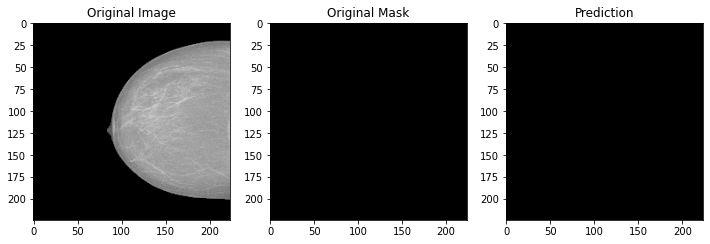

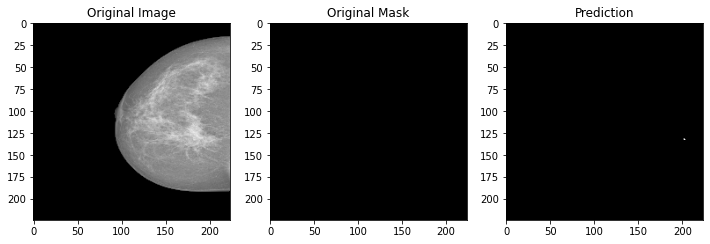

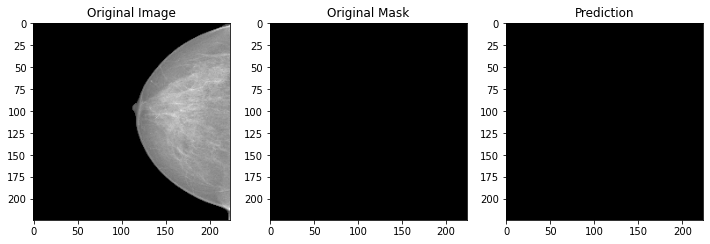

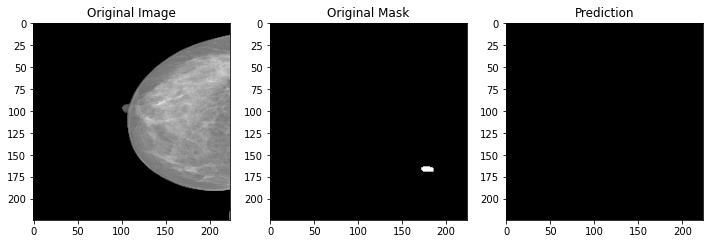

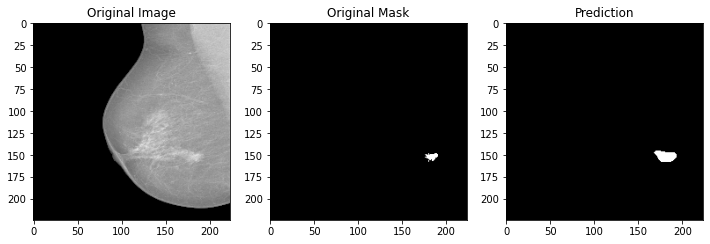

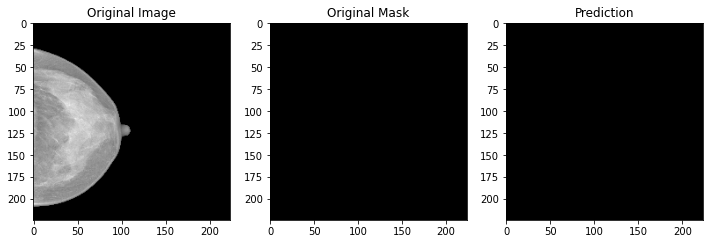

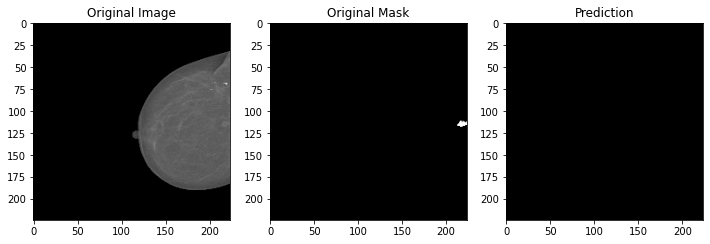

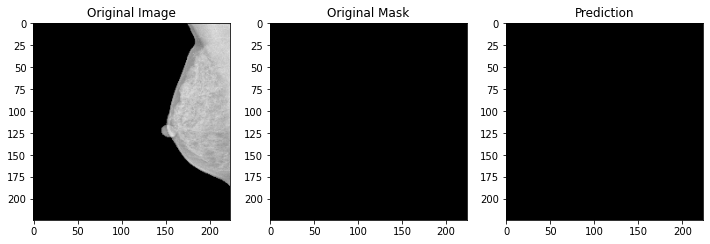

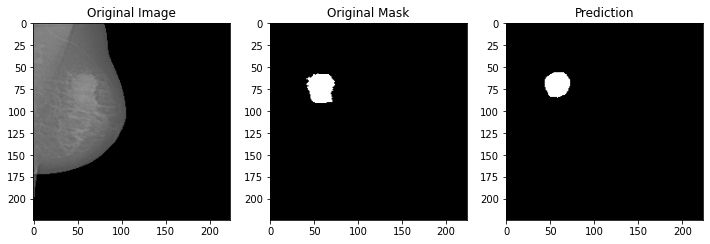

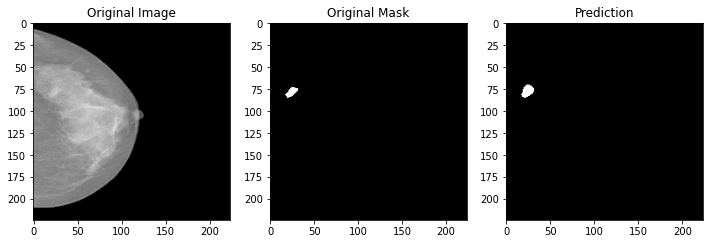

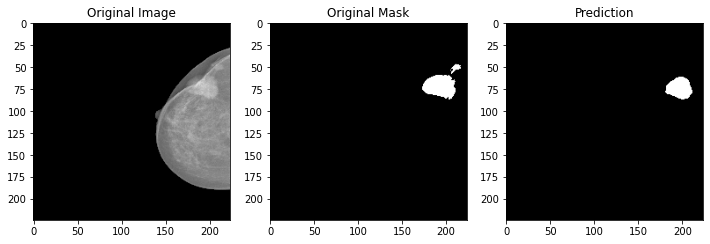

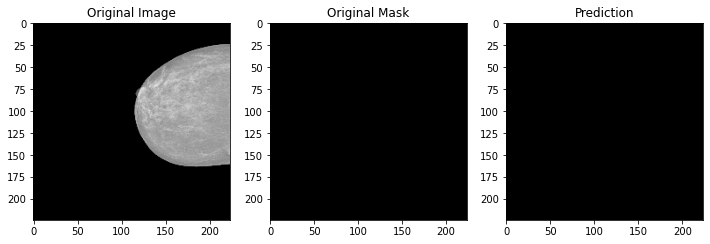

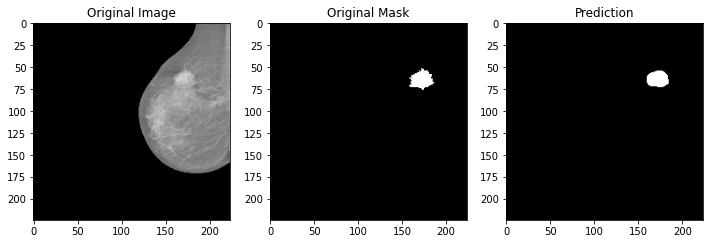

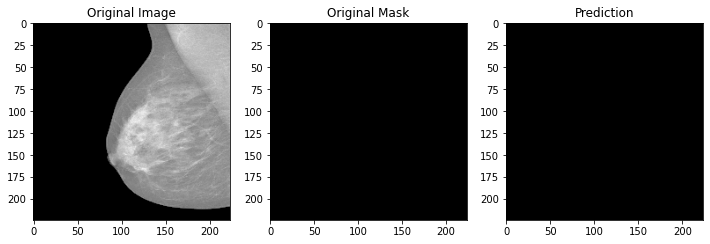

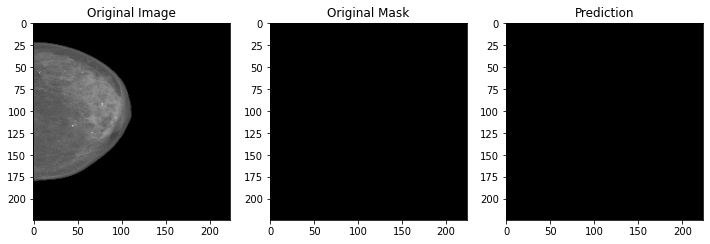

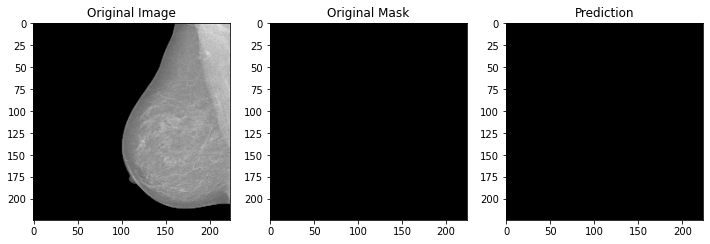

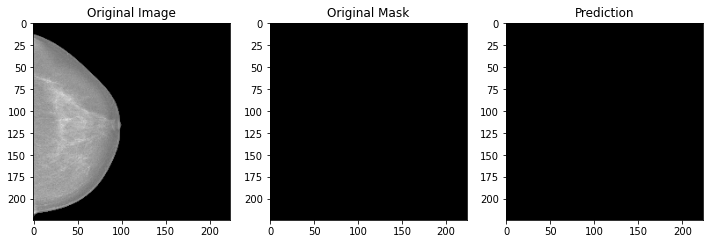

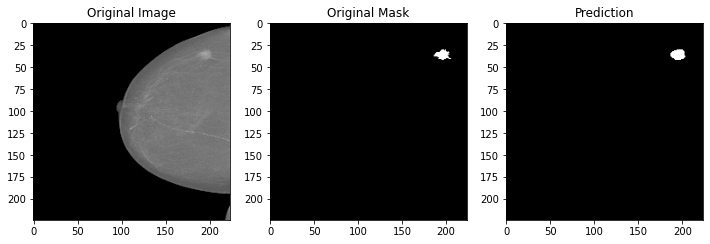

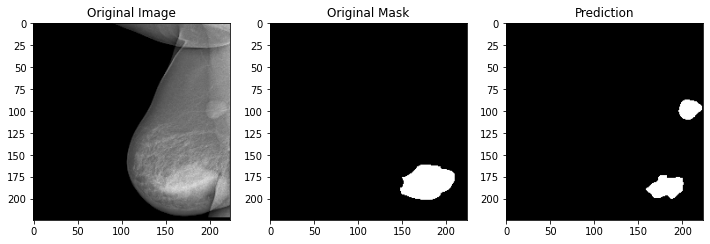

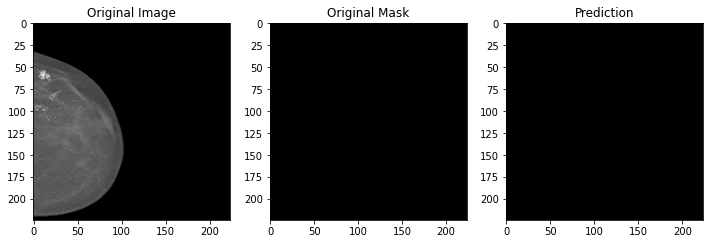

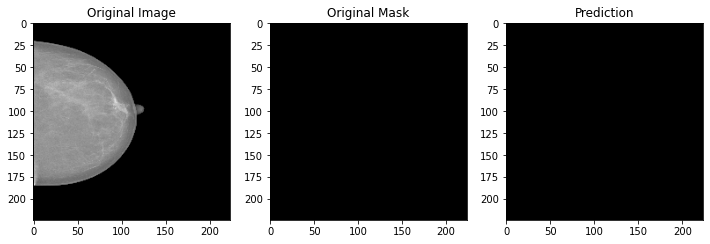

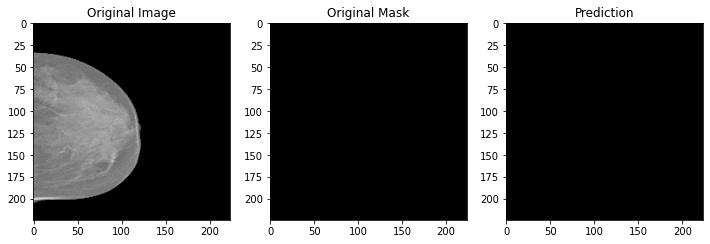

In [27]:
im_height, im_width = 224,224
for i in range(22):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[i])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model_resnet2.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    mask = np.squeeze(cv2.imread(df_test['mask'].iloc[i]))
    mask = cv2.resize(mask ,(im_height, im_width))
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5,cmap='gray')
    plt.title('Prediction')
    plt.show()

## ResUnet Transfer Learning with freezing the encoder

In [28]:
from segmentation_models import metrics
# define model
model_resnet3 = sm.Unet(BACKBONE,encoder_weights='imagenet',encoder_freeze=True)
# model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model_resnet3.compile(optimizer=opt, loss=[sm.losses.bce_dice_loss, sm.losses.bce_jaccard_loss], 
                     metrics=[sm.metrics.precision, sm.metrics.recall, sm.metrics.f1_score, sm.metrics.iou_score])
print(model_resnet3.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 2D)                            128)                                                              
                                                                                                  
 stage2_unit1_conv2 (Conv2D)    (None, None, None,   147456      ['zero_padding2d_43[0][0]']      
                                128)                                                              
                                                                                                  
 stage2_unit1_sc (Conv2D)       (None, None, None,   8192        ['stage2_unit1_relu1[0][0]']     
                                128)                                                              
                                                                                                  
 add_19 (Add)                   (None, None, None,   0           ['stage2_unit1_conv2[0][0]',     
                                128)                              'stage2_unit1_sc[0][0]']        
          

Found 153 validated image filenames.
Found 153 validated image filenames.
Epoch 1/150
10/10 [==============================] - ETA: 0s - loss: 1.2742 - precision: 0.0041 - recall: 0.2237 - f1-score: 0.0080 - iou_score: 0.0040Found 39 validated image filenames.
Found 39 validated image filenames.

Epoch 1: val_loss improved from inf to 1.52014, saving model to /content/drive/MyDrive/ModelCheckpoint/ResUnet Transfer Learning with freezing the encoder.hdf5
10/10 [==============================] - 78s 8s/step - loss: 1.2742 - precision: 0.0041 - recall: 0.2237 - f1-score: 0.0080 - iou_score: 0.0040 - val_loss: 1.5201 - val_precision: 0.0069 - val_recall: 0.4094 - val_f1-score: 0.0134 - val_iou_score: 0.0068
Epoch 2/150
10/10 [==============================] - ETA: 0s - loss: 1.2271 - precision: 0.0052 - recall: 0.2433 - f1-score: 0.0101 - iou_score: 0.0051
Epoch 2: val_loss did not improve from 1.52014
10/10 [==============================] - 68s 7s/step - loss: 1.2271 - precision: 0.0052 

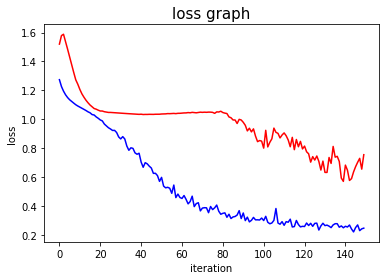

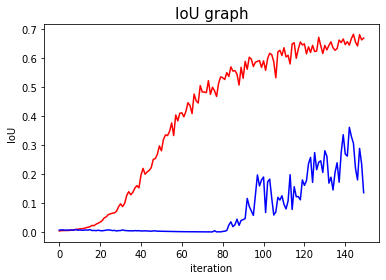

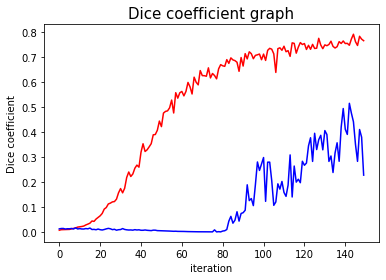

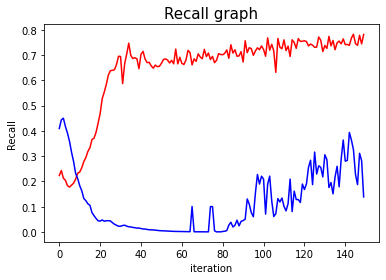

In [29]:
train_generator_args = dict(rotation_range=0.5,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.05,
                            zoom_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
callbacks = [ModelCheckpoint('/content/drive/MyDrive/ModelCheckpoint/ResUnet Transfer Learning with freezing the encoder.hdf5', verbose=1, save_best_only=True)]

history = model_resnet3.fit(train_gen,
                    steps_per_epoch=10, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=10)

## plotting curves

a = history.history

plt.figure(1)
plt.plot(a['loss'], 'b-')
plt.plot(a['val_loss'],'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)


plt.figure(2)
plt.plot(a['iou_score'], 'r-')
plt.plot(a['val_iou_score'], 'b-')
plt.xlabel('iteration')
plt.ylabel('IoU')
plt.title('IoU graph', fontsize = 15)


plt.figure(3)
plt.plot(a['f1-score'], 'r-')
plt.plot(a['val_f1-score'], 'b-')
plt.xlabel('iteration')
plt.ylabel('Dice coefficient')
plt.title('Dice coefficient graph', fontsize = 15)

plt.figure(4)
plt.plot(a['recall'], 'r-')
plt.plot(a['val_recall'], 'b-')
plt.xlabel('iteration')
plt.ylabel('Recall')
plt.title('Recall graph', fontsize = 15)

plt.show()

In [30]:
test_gen = train_generator(df_test, 22,
                                dict(),
                                target_size=(224, 224))
results = model_resnet3.evaluate(test_gen, steps=10)

Found 22 validated image filenames.
Found 22 validated image filenames.
10/10 [==============================] - 24s 3s/step - loss: 0.4235 - precision: 0.6633 - recall: 0.5390 - f1-score: 0.5947 - iou_score: 0.4232


In [31]:
print("Test lost:   ",results[0])
print("precision:   ",results[1])
print("Recall   :   ",results[2])
print("f1-score :   ",results[3])
print("iou_score:   ",results[4])

Test lost:    0.4234677851200104
precision:    0.6633111238479614
Recall   :    0.5390153527259827
f1-score :    0.5947384834289551
iou_score:    0.4232226312160492


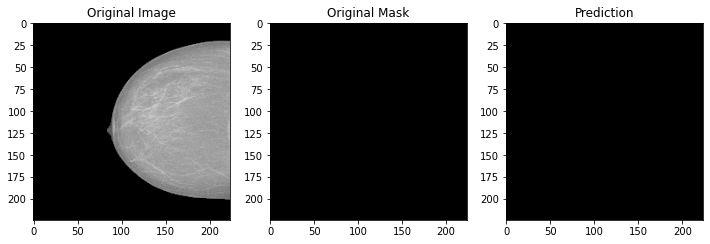

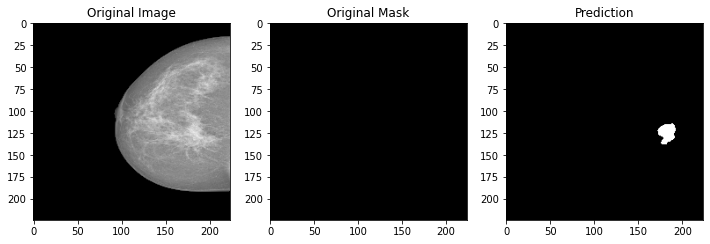

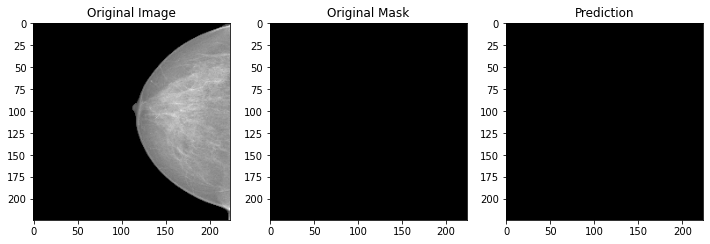

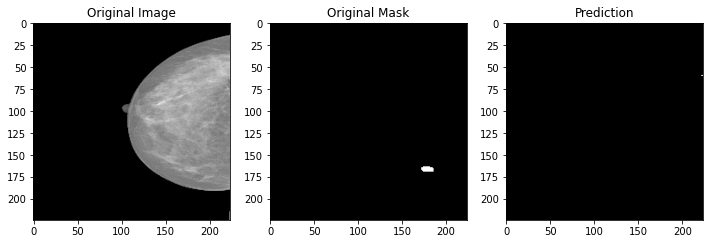

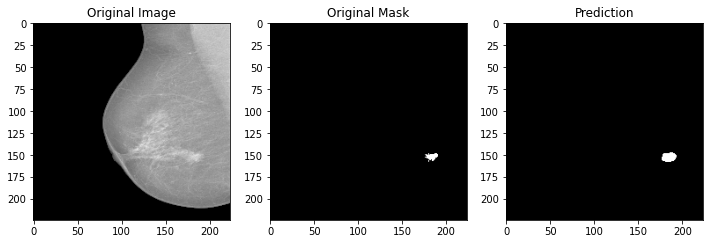

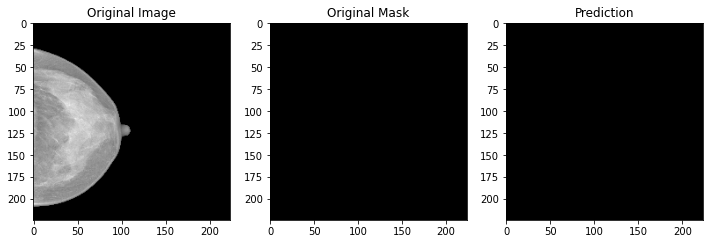

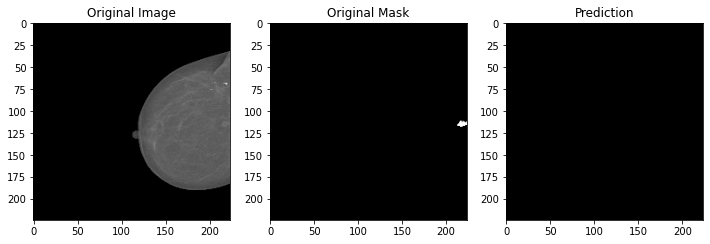

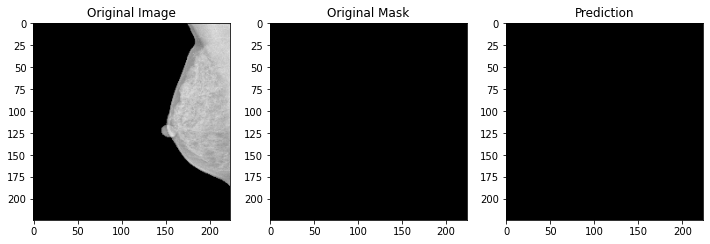

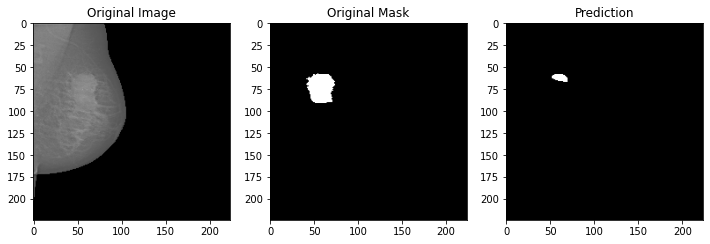

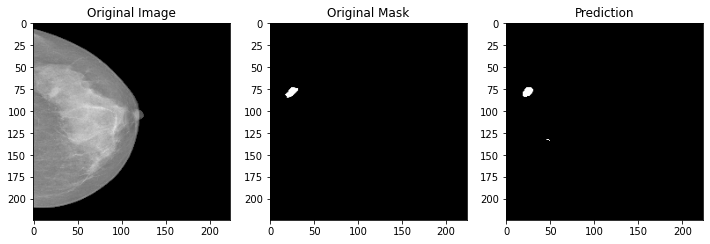

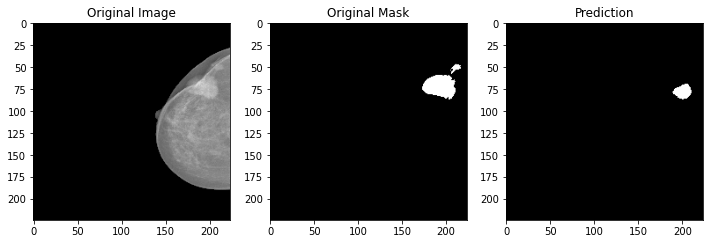

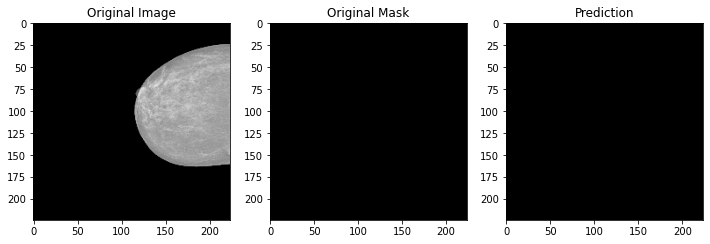

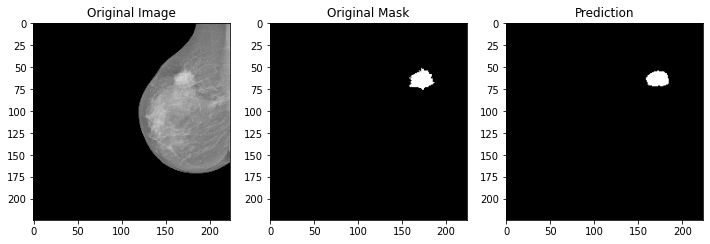

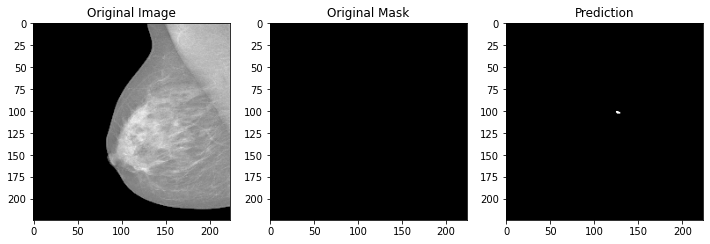

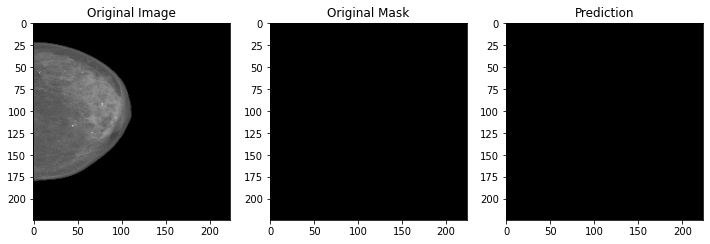

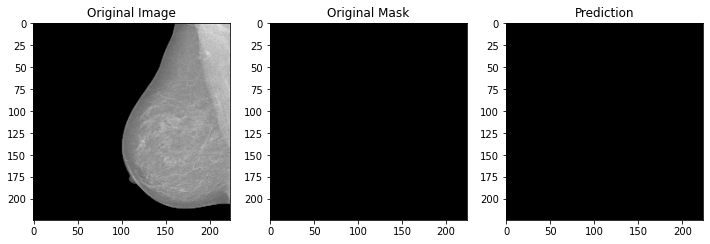

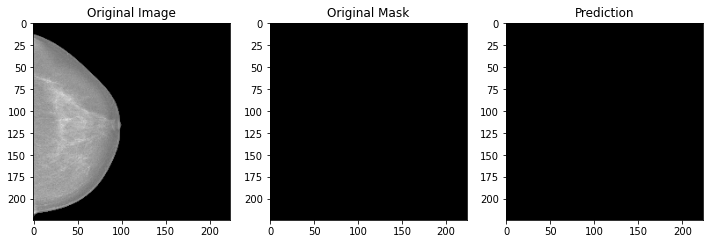

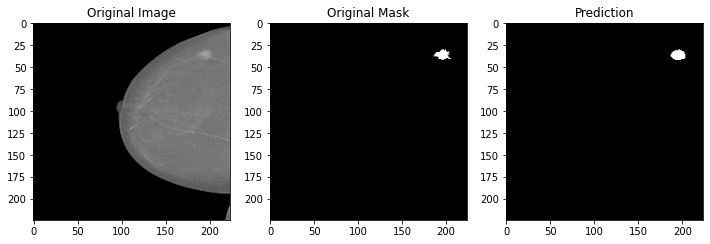

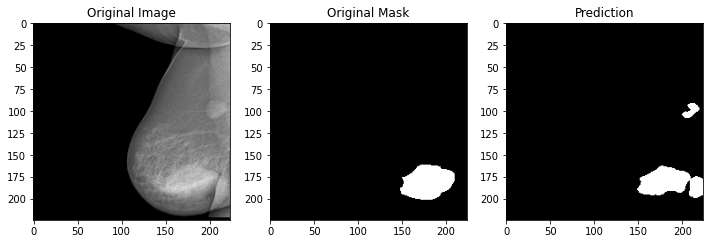

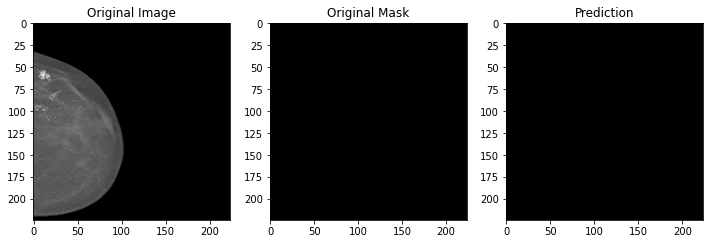

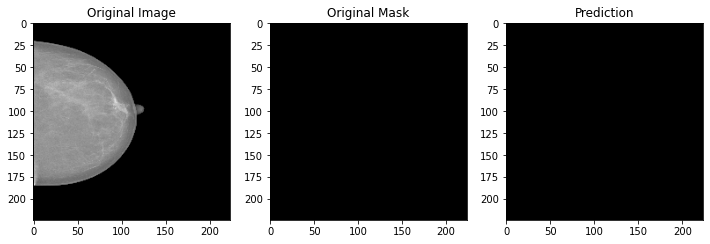

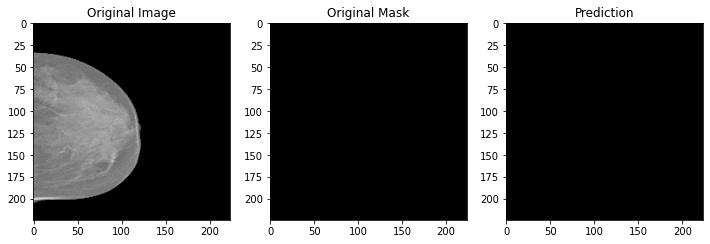

In [32]:
im_height, im_width = 224,224
for i in range(22):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[i])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model_resnet3.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    mask = np.squeeze(cv2.imread(df_test['mask'].iloc[i]))
    mask = cv2.resize(mask ,(im_height, im_width))
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5,cmap='gray')
    plt.title('Prediction')
    plt.show()